# Import packages

In [ ]:
%load_ext autoreload
%autoreload 2

import os, sys, sys
from pathlib import Path
for p in [Path.cwd()] + list(Path.cwd().parents):
    if p.name == 'Multifirefly-Project':
        os.chdir(p)
        sys.path.insert(0, str(p / 'multiff_analysis/multiff_code/methods'))
        break
    
from data_wrangling import specific_utils, process_monkey_information, general_utils
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from neural_data_analysis.neural_analysis_tools.get_neural_data import neural_data_processing
from neural_data_analysis.neural_analysis_tools.visualize_neural_data import plot_neural_data, plot_modeling_result, tuning_curve, raster_plot, trial_aligned_tuning_curve
from neural_data_analysis.neural_analysis_tools.test_neural_response import compare_firing_rate
from neural_data_analysis.neural_analysis_tools.model_neural_data import transform_vars, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from neural_data_analysis.topic_based_neural_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from neural_data_analysis.topic_based_neural_analysis.planning_and_neural import planning_and_neural_class, pn_utils, pn_helper_class, pn_aligned_by_seg, pn_aligned_by_event
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class, cca_utils, cca_cv_utils
from neural_data_analysis.neural_analysis_tools.cca_methods.cca_plotting import cca_plotting, cca_plot_lag_vs_no_lag, cca_plot_cv
from machine_learning.ml_methods import regression_utils, regz_regression_utils, ml_methods_class, classification_utils, ml_plotting_utils, ml_methods_utils
from planning_analysis.show_planning import nxt_ff_utils, show_planning_utils
from neural_data_analysis.neural_analysis_tools.gpfa_methods import elephant_utils, fit_gpfa_utils, plot_gpfa_utils, gpfa_helper_class
from neural_data_analysis.neural_analysis_tools.align_trials import time_resolved_regression, plot_time_resolved_regression

import sys
import math
import gc
import subprocess
from pathlib import Path
from importlib import reload

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca
import quantities as pq

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# retrieve data

In [9]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0321"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0329"

In [3]:
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0312"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0316"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0327"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0328"

In [10]:
reduce_y_var_lags = False
planning_data_by_point_exists_ok = True
y_data_exists_ok = False

pn = pn_aligned_by_event.PlanningAndNeuralEventAligned(raw_data_folder_path=raw_data_folder_path)
pn.prep_data_to_analyze_planning(planning_data_by_point_exists_ok=planning_data_by_point_exists_ok,
                                 add_behav_data=False,
                                 put_data_into_bins=False)
pn.load_raw_data()
pn.spikes_df = neural_data_processing.make_spikes_df(pn.raw_data_folder_path, pn.ff_caught_T_sorted, sampling_rate=pn.sampling_rate)

Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Schro/data_0416/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Schro/data_0416/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-50cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Schro/data_0416/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-50cm_0cm
Overlap: []
Percentage overlap relative to df1: 0.00%
Percentage overlap relative to df2: 0.00%
Average percentage overlap: 0.00%
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new


In [5]:
#event_df = pn.get_new_ff_first_or_last_time(cur_or_nxt='cur', first_or_last='first', time_limit_to_count_sighting=2)          
pn.get_new_seg_info(cur_or_nxt='cur', first_or_last='first', time_limit_to_count_sighting=2, pre_event_window=0.25, post_event_window=0.75, exists_ok=False)

new_seg_duration is now 1.0, and post_event_window is now 0.75
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Schro/data_0416/ff_dataframe.h5
Dropped 26 out of 152 segments because of insufficient duration, which is 17.1% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Schro/data_0416/new_seg_info/tlim2_pre0p25_post0p75.csv


event_time  segment  stop_time  prev_ff_caught_time  new_segment  \
0      23.01927        0   25.01125             17.07656            0   
1      27.50133        1   29.41040             25.01125            1   
2      30.42273        2   31.90023             29.41040            2   
3      49.49614        3   50.94039             48.50003            3   
4      56.53438        5   56.98268             51.57103            4   
..          ...      ...        ...                  ...          ...   
121  2283.94837      145 2285.25989           2282.38800          121   
122  2290.05707      147 2292.04920           2289.19398          122   
123  2293.37713      148 2294.55570           2292.04920          123   
124  2316.31797      150 2316.74978           2310.04345          124   
125  2392.97626      151 2393.73961           2390.20384          125   

     new_seg_start_time  new_seg_end_time  new_seg_duration  
0              22.76927          23.76927           1.00000  
1              27.25133          28.25133           1.00000  
2              30.17273          31.17273           1.00000  
3              49.24614          50.24614           1.00000  
4              56.28438          57.28438           1.00000  
..                  ...               ...               ...  
121          2283.69837        2284.69837           1.00000  
122          2289.80707        2290.80707           1.00000  
123          2293.12713        2294.12713           1.00000  
124          2316.06797        2317.06797           1.00000  
125          2392.72626        2393.72626           1.00000  

[126 rows x 8 columns]

# trial-averaged tuning curve

In [ ]:
# distribute data into new_segments and add rel_spike_time
pn.get_new_seg_info(cur_or_nxt='nxt', first_or_last='first', time_limit_to_count_sighting=2, pre_event_window=0.75, post_event_window=0.75, exists_ok=False)


new_seg_duration is now 1.5, and post_event_window is now 0.75
Dropped 26 out of 152 segments because of insufficient duration, which is 17.1% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Schro/data_0416/new_seg_info/tlim2_pre0p75_post0p75.csv
Dropped 55 rows out of 126 due to NA in new_seg_start_time or new_seg_end_time, which is 69.65% of the original data


In [72]:
time_before_event = 0.9
time_after_event = 0.9
n_bins = 6

new_seg_info2 = pn.new_seg_info.copy()
new_seg_info2['new_seg_start_time'] = new_seg_info2['event_time'] - time_before_event
new_seg_info2['new_seg_end_time'] = new_seg_info2['event_time'] + time_after_event
aligned_spike_trains = raster_plot.prepare_aligned_spike_trains(new_seg_info2, pn.spikes_df)

Dropped 55 rows out of 126 due to NA in new_seg_start_time or new_seg_end_time, which is 69.65% of the original data


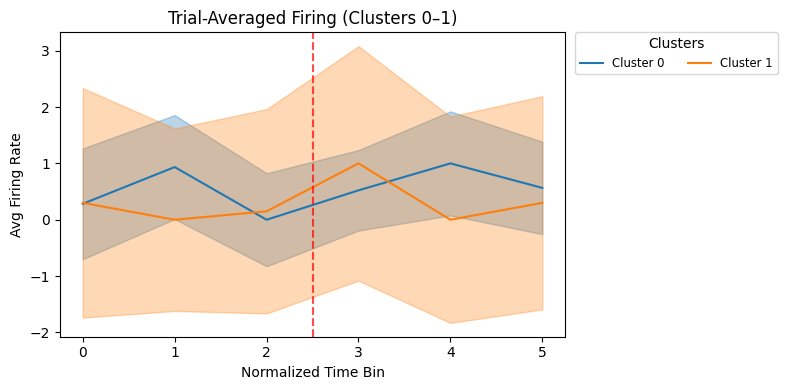

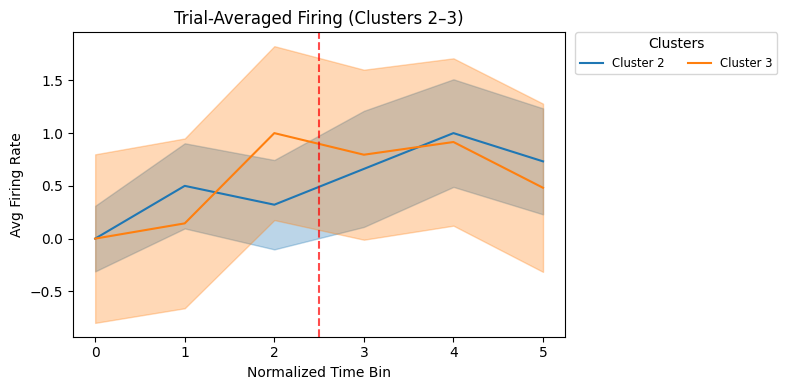

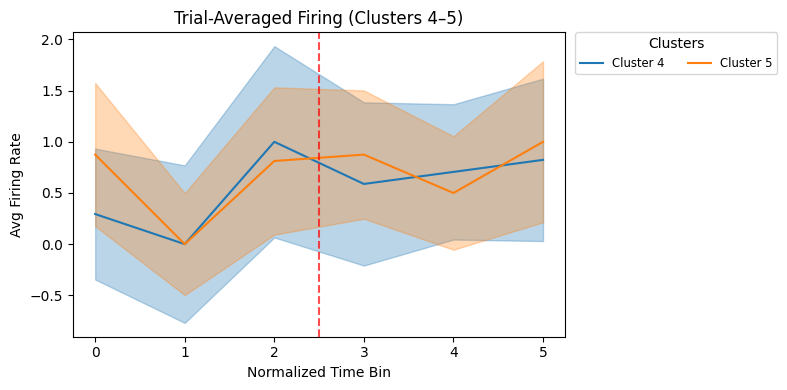

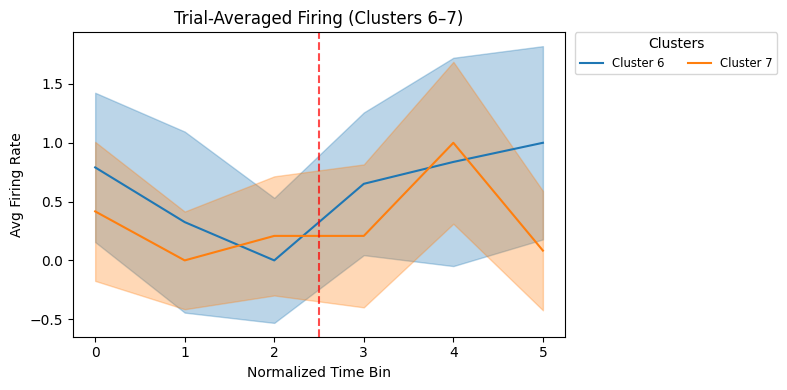

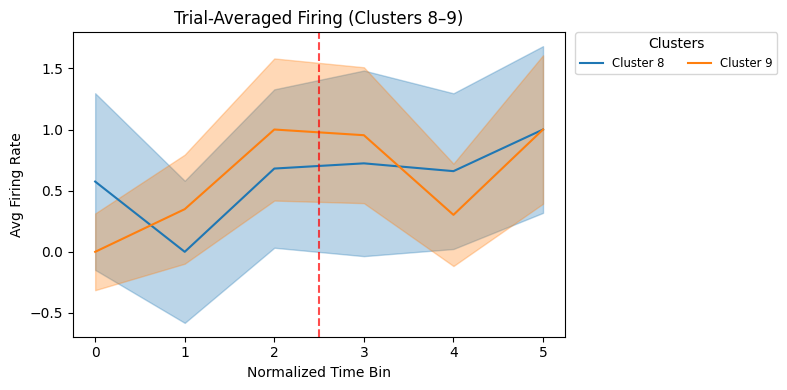

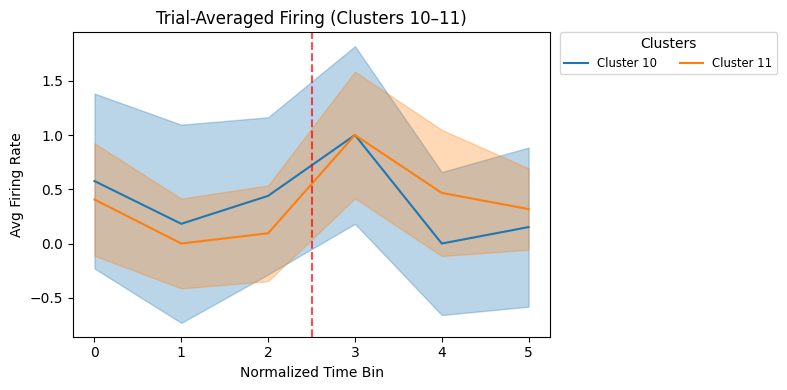

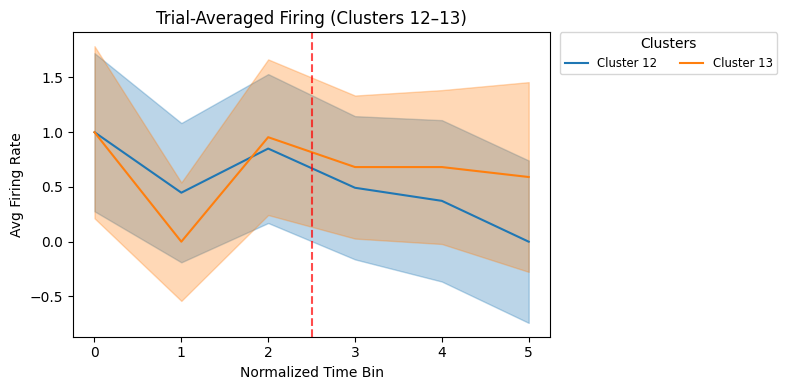

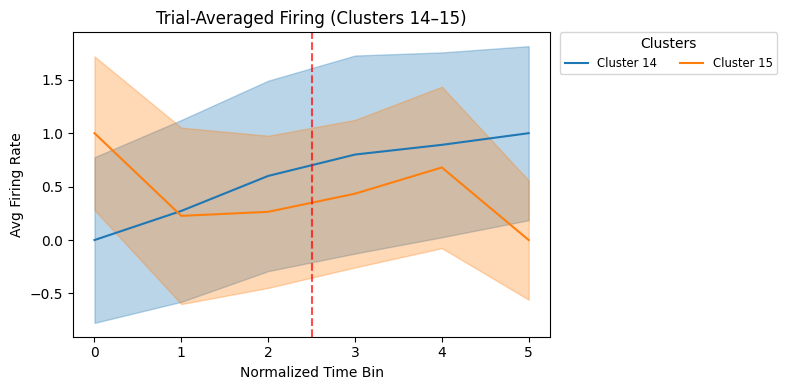

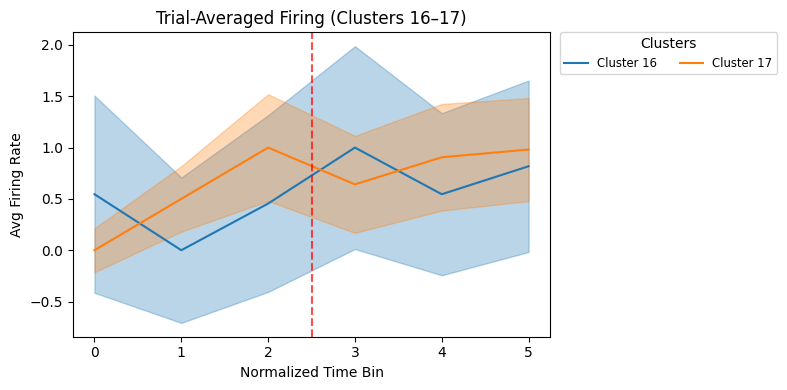

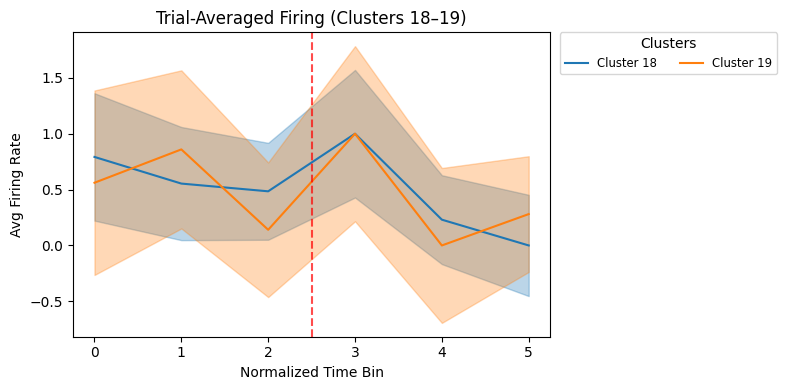

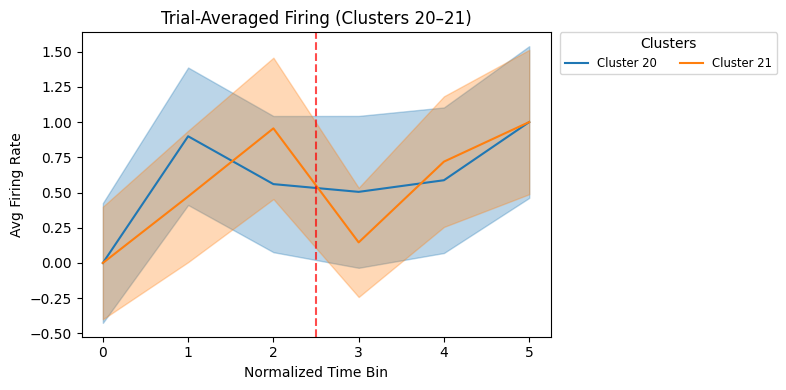

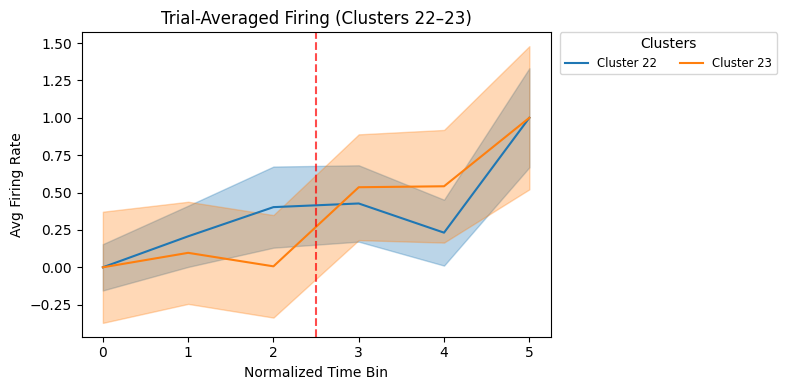

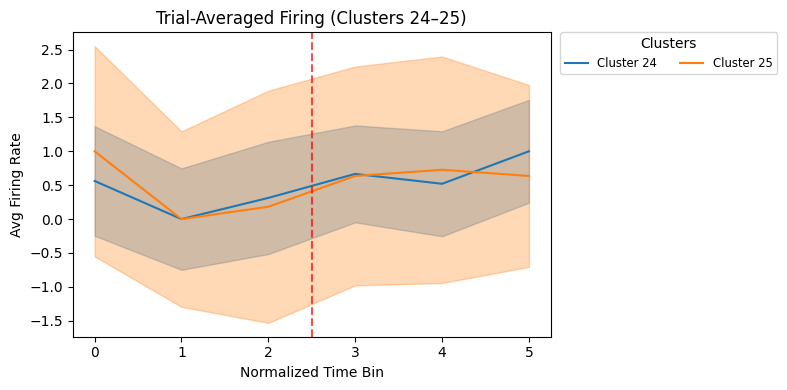

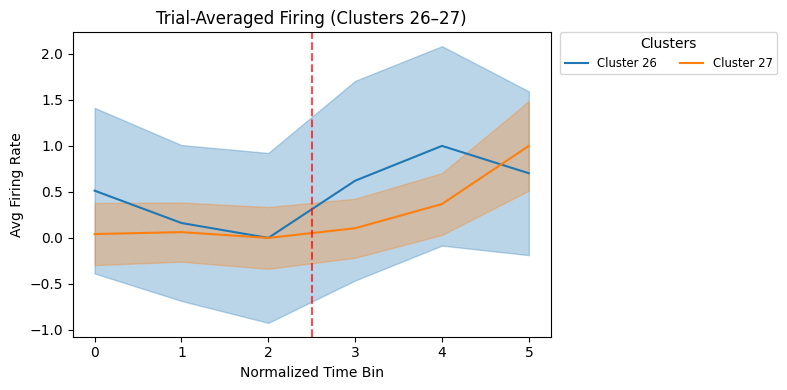

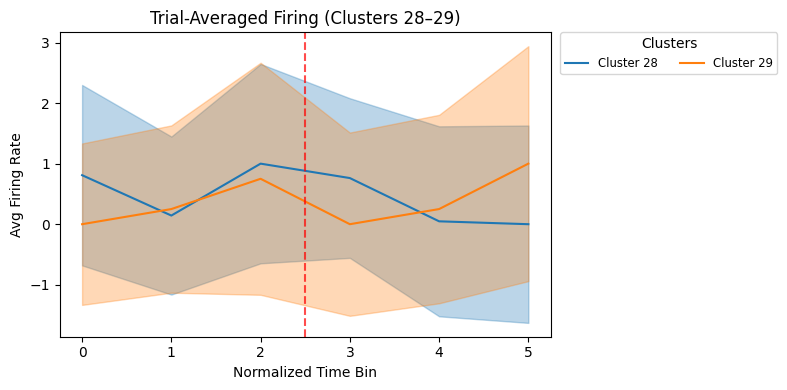

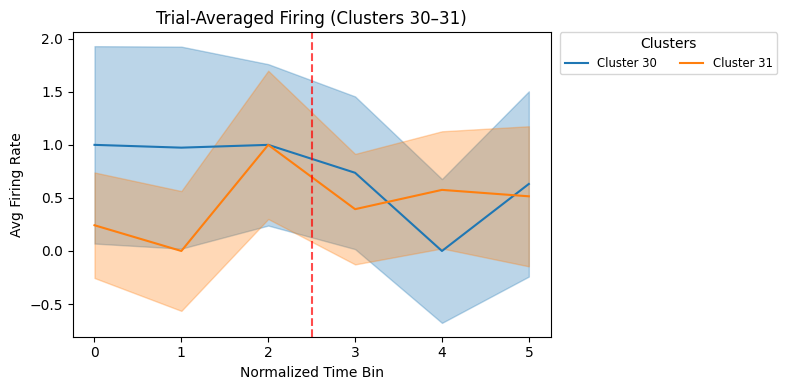

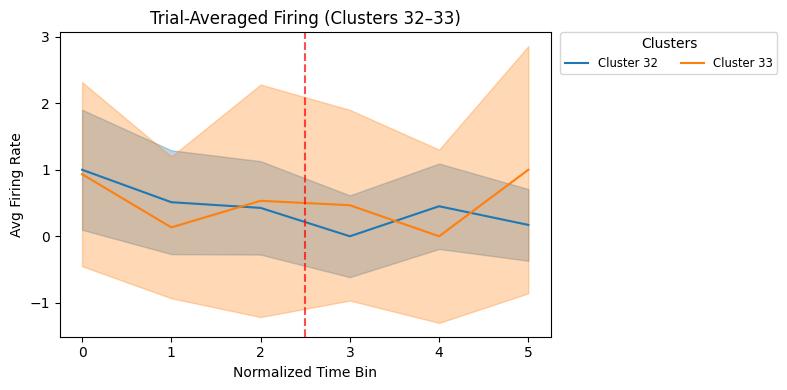

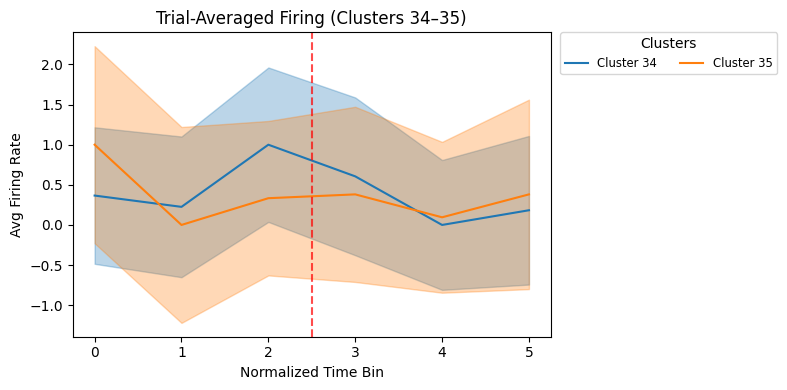

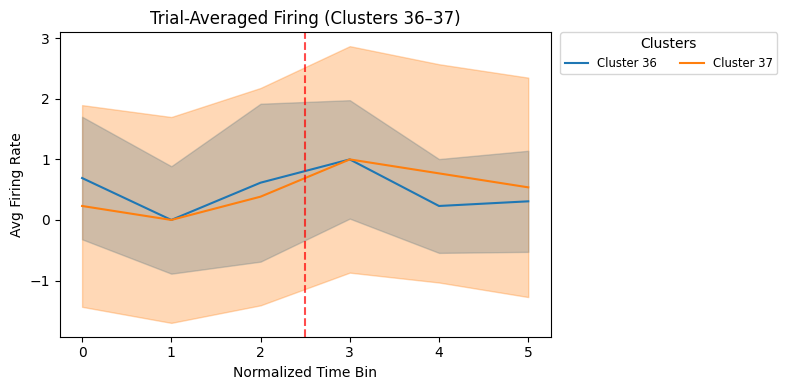

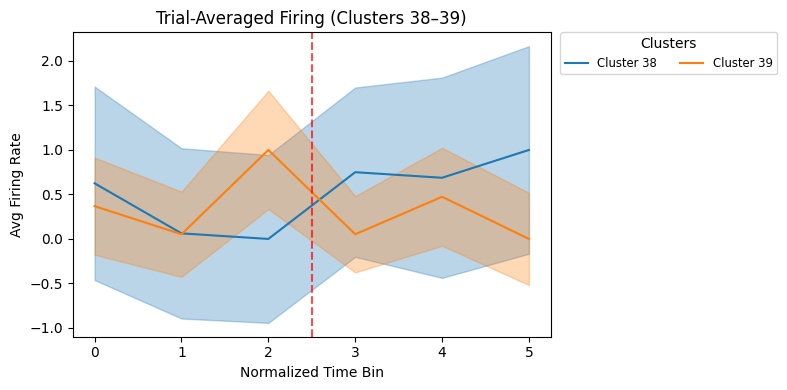

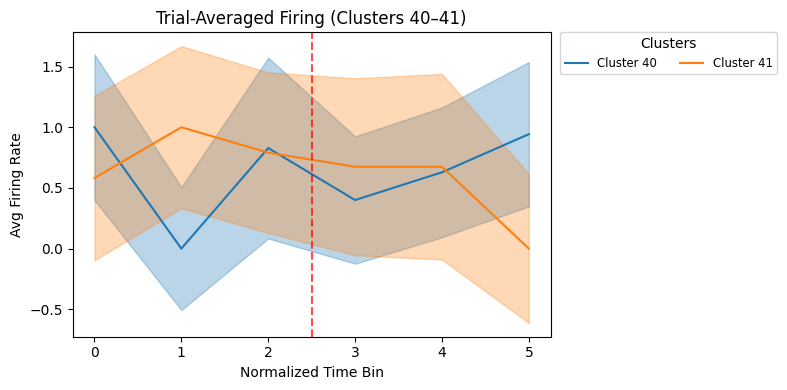

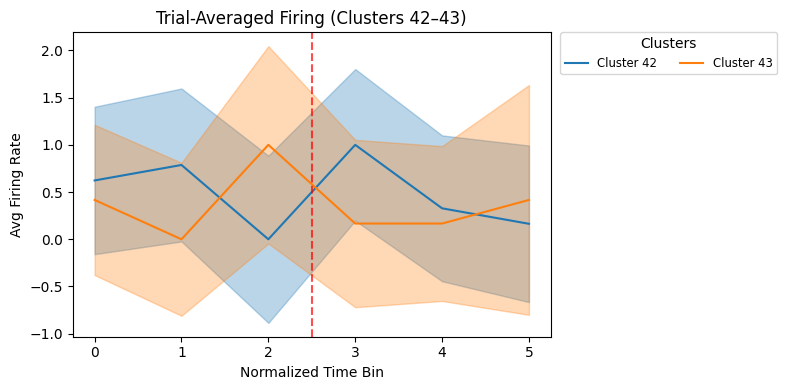

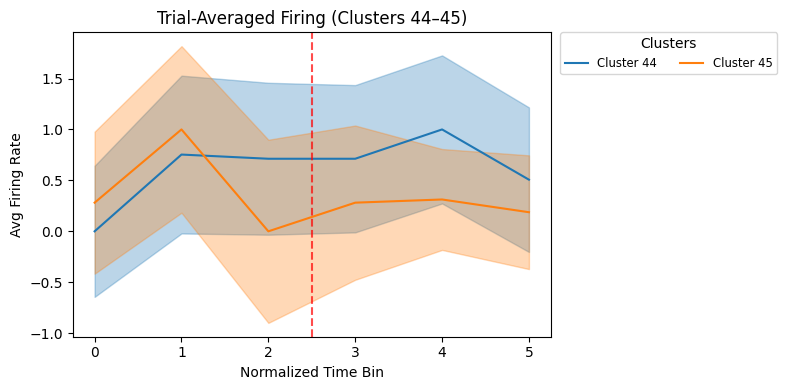

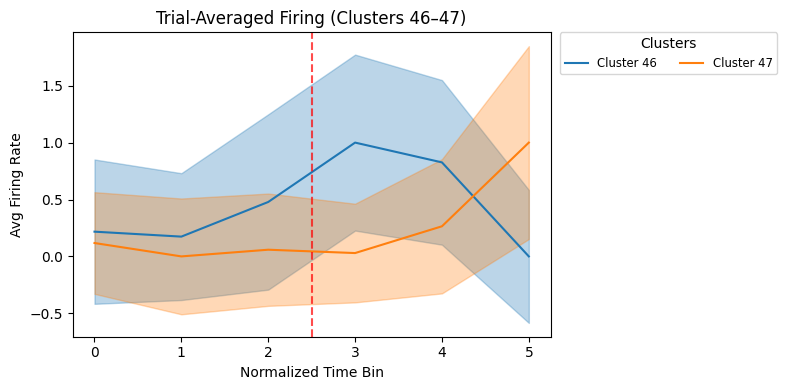

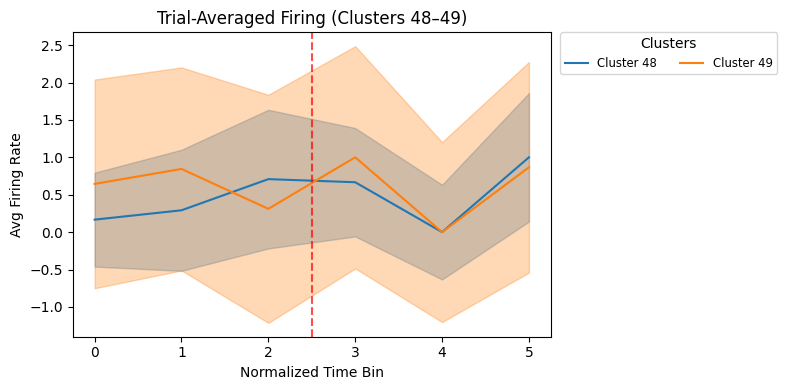

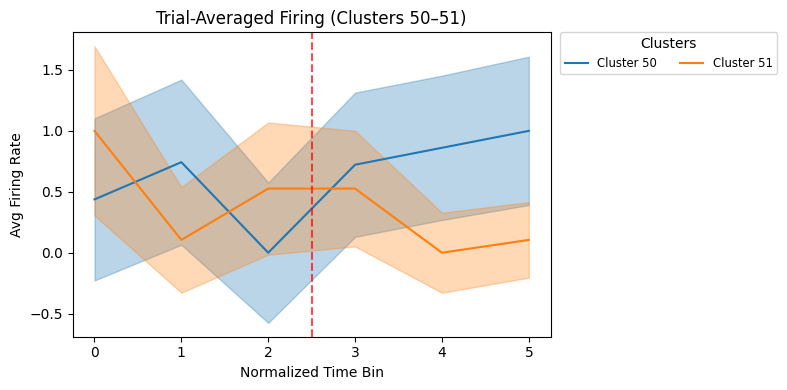

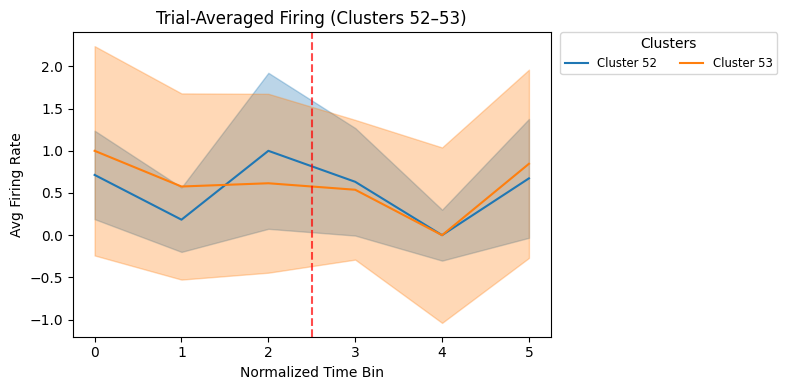

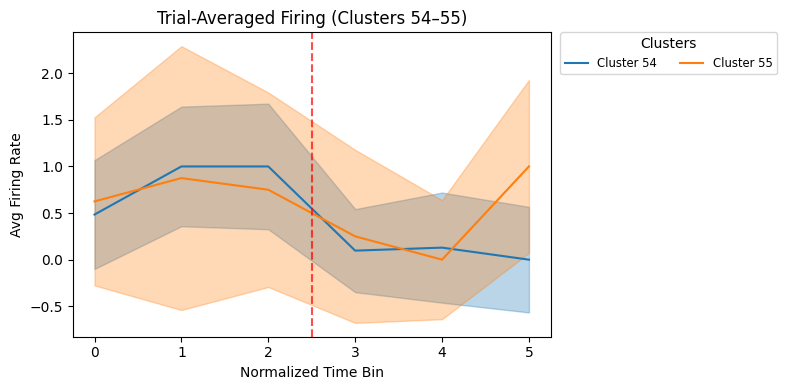

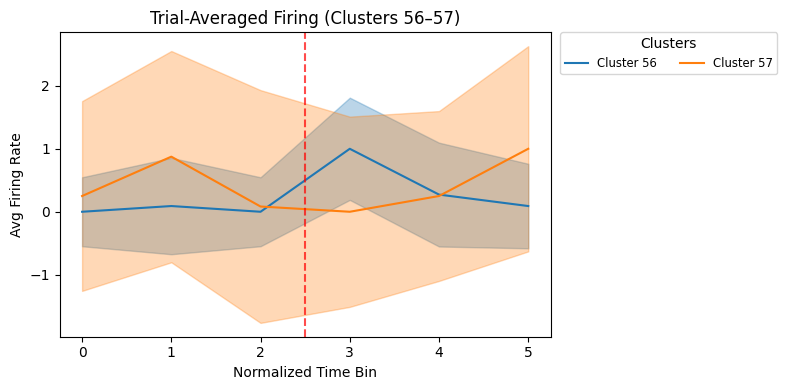

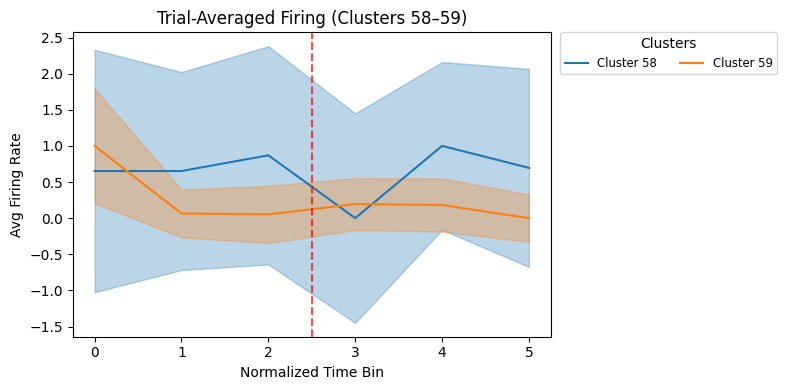

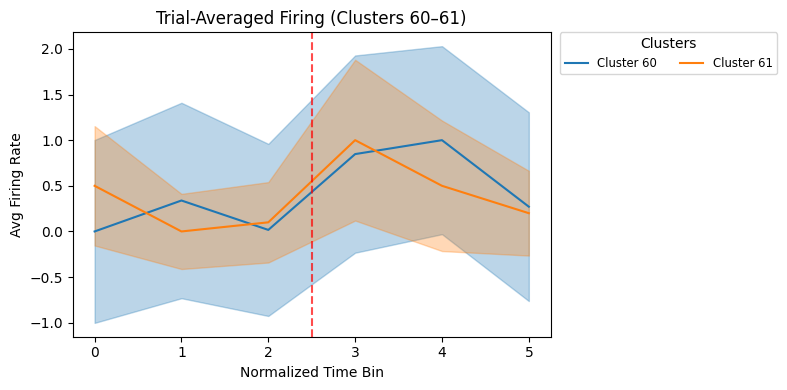

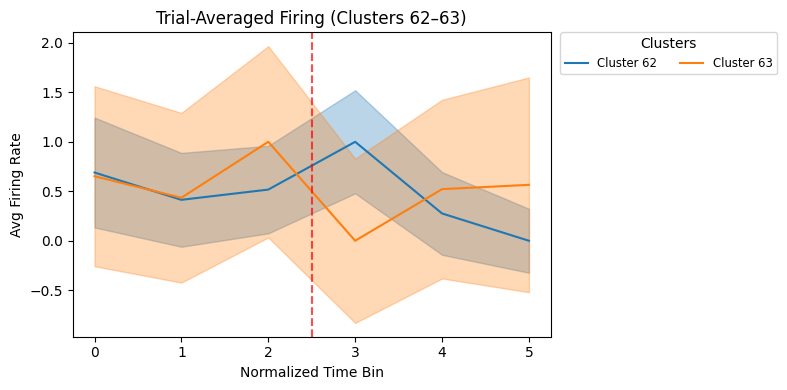

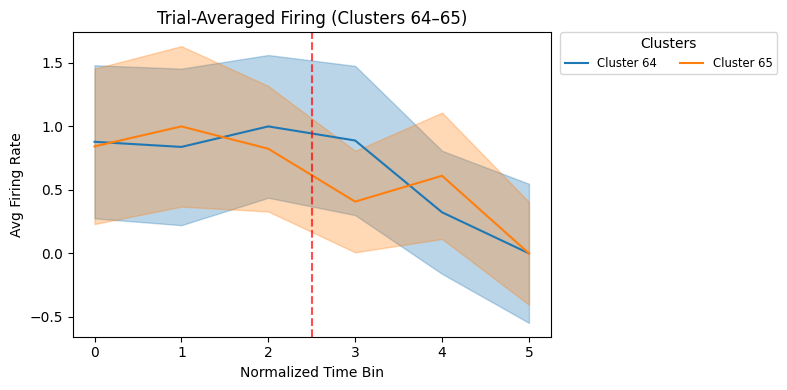

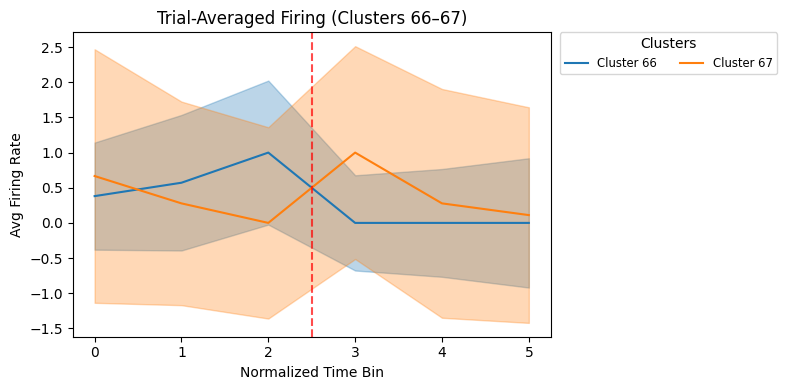

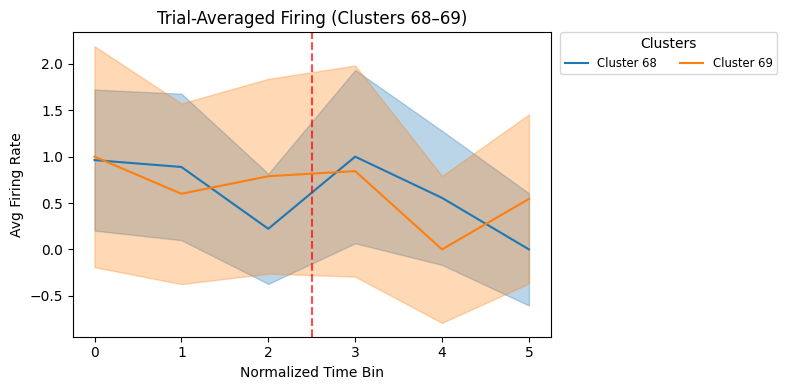

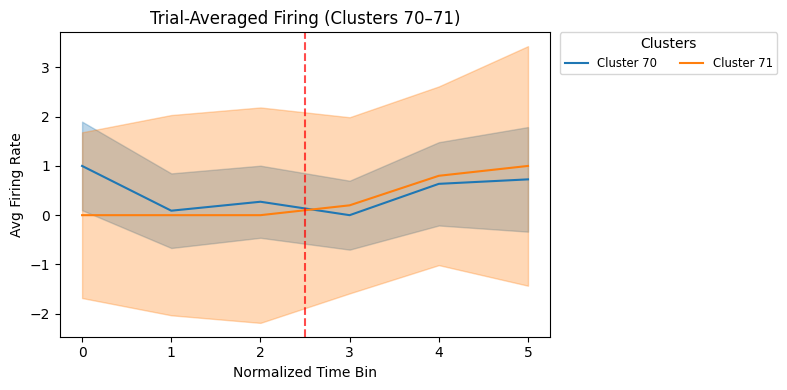

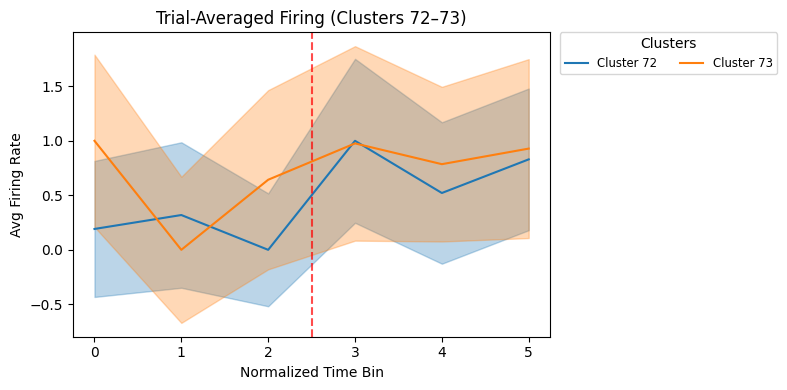

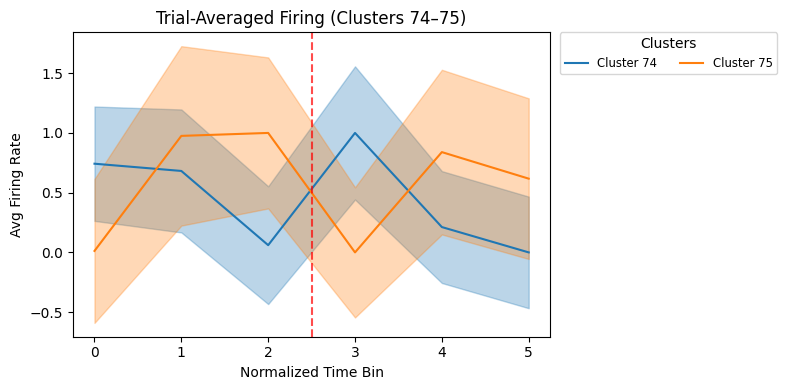

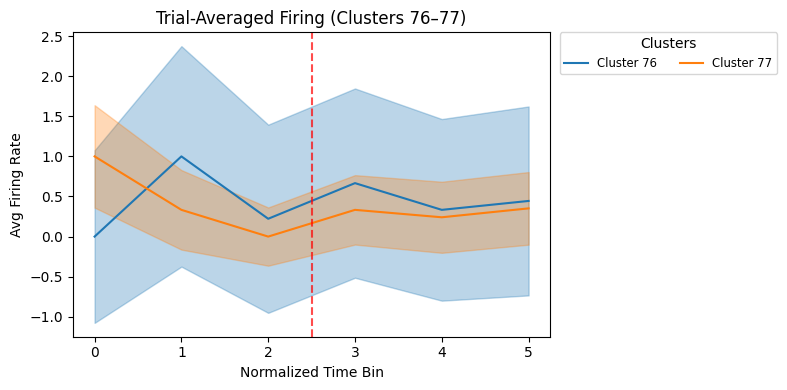

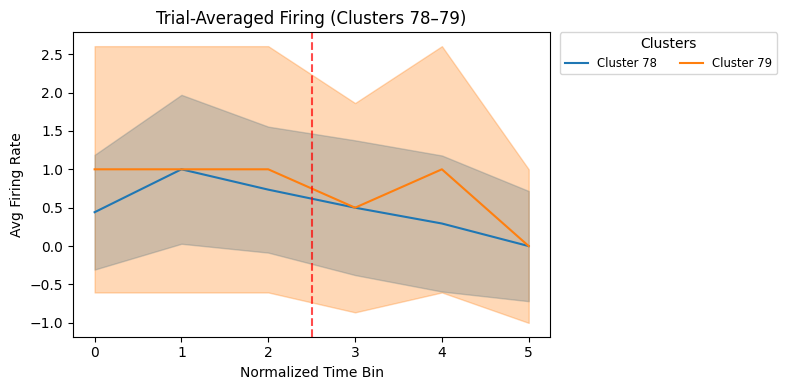

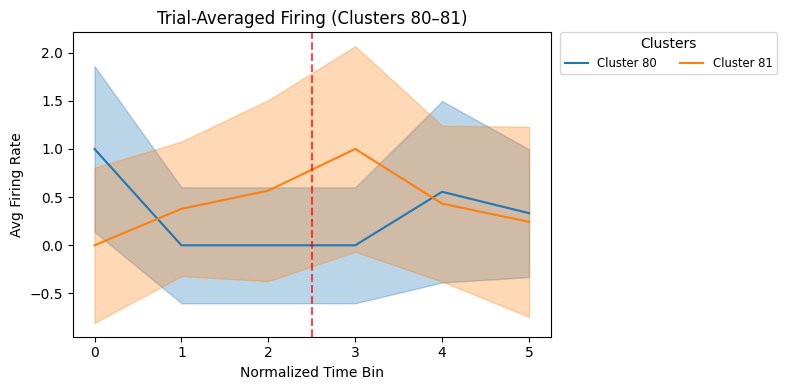

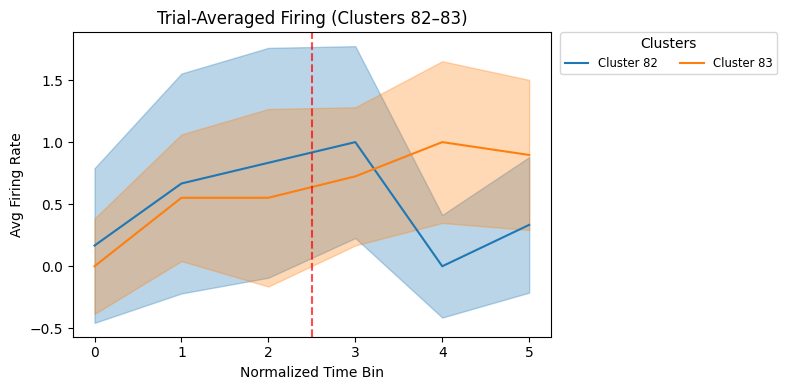

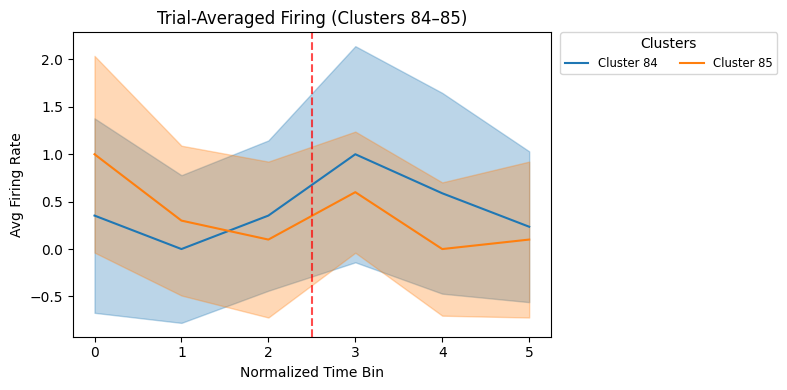

In [ ]:
duration = time_before_event + time_after_event
last_bin_index = n_bins - 1
event_x_position = time_before_event/duration * last_bin_index
aligned_spike_trains = trial_aligned_tuning_curve.prepare_trial_aligned_tuning_curve_data(aligned_spike_trains)
firing_df, avg_firing_df = trial_aligned_tuning_curve.trial_averaged_time_normalized_firing(aligned_spike_trains, 
                                                                                            n_bins=n_bins, 
                                                                                            clusters_per_fig=3,
                                                                                            rescale_avg_firing_rate=True,
                                                                                            event_x_position=event_x_position)

# tuning curve

In [ ]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0328"

reduce_y_var_lags = False
planning_data_by_point_exists_ok = True
y_data_exists_ok = False

pn = pn_aligned_by_event.PlanningAndNeuralEventAligned(raw_data_folder_path=raw_data_folder_path)
pn.prep_data_to_analyze_planning(planning_data_by_point_exists_ok=planning_data_by_point_exists_ok,
                                 add_behav_data=False,
                                 put_data_into_bins=False)

Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0328/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0328/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-50cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0328/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-50cm_0cm
Overlap: []
Percentage overlap relative to df1: 0.00%
Percentage overlap relative to df2: 0.00%
Average percentage overlap: 0.00%


In [ ]:
pn.prepare_seg_aligned_data()
pn.get_concat_data_for_regression(use_raw_spike_data_instead=True,
                                  apply_pca_on_raw_spike_data=False,
                                  use_lagged_raw_spike_data=False) 

new_seg_duration is now 1.0, and post_event_window is now 0.75
Loaded new_seg_info from all_monkey_data/planning_and_neural/monkey_Bruno/data_0328/new_seg_info/tlim2_pre0p25_post0p75.csv
Dropped 10 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'cur_opt_arc_curv', 'nxt_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'cur_cntr_arc_end_heading', 'angle_opt_arc_from_cur_end_to_nxt', 'angle_cntr_arc_from_cur_end_to_nxt', 'abs_angle_opt_arc_from_cur_end_to_nxt', 'abs_angle_cntr_arc_from_cur_end_to_nxt']
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new

No NA values found in DataFrame

No NA values found in DataFrame


In [ ]:
var_of_interest = 'cur_ff_distance'
flat_spikes = pn.concat_neural_trials[[col for col in pn.concat_neural_trials.columns if 'cluster_' in col]].values
flat_stimulus_values = pn.concat_behav_trials[var_of_interest].values.flatten()
tuning_curves = tuning_curve.compute_tuning_curves_pooled(flat_spikes, flat_stimulus_values, 
                                                         n_stimulus_bins=20, variable_type='continuous')


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


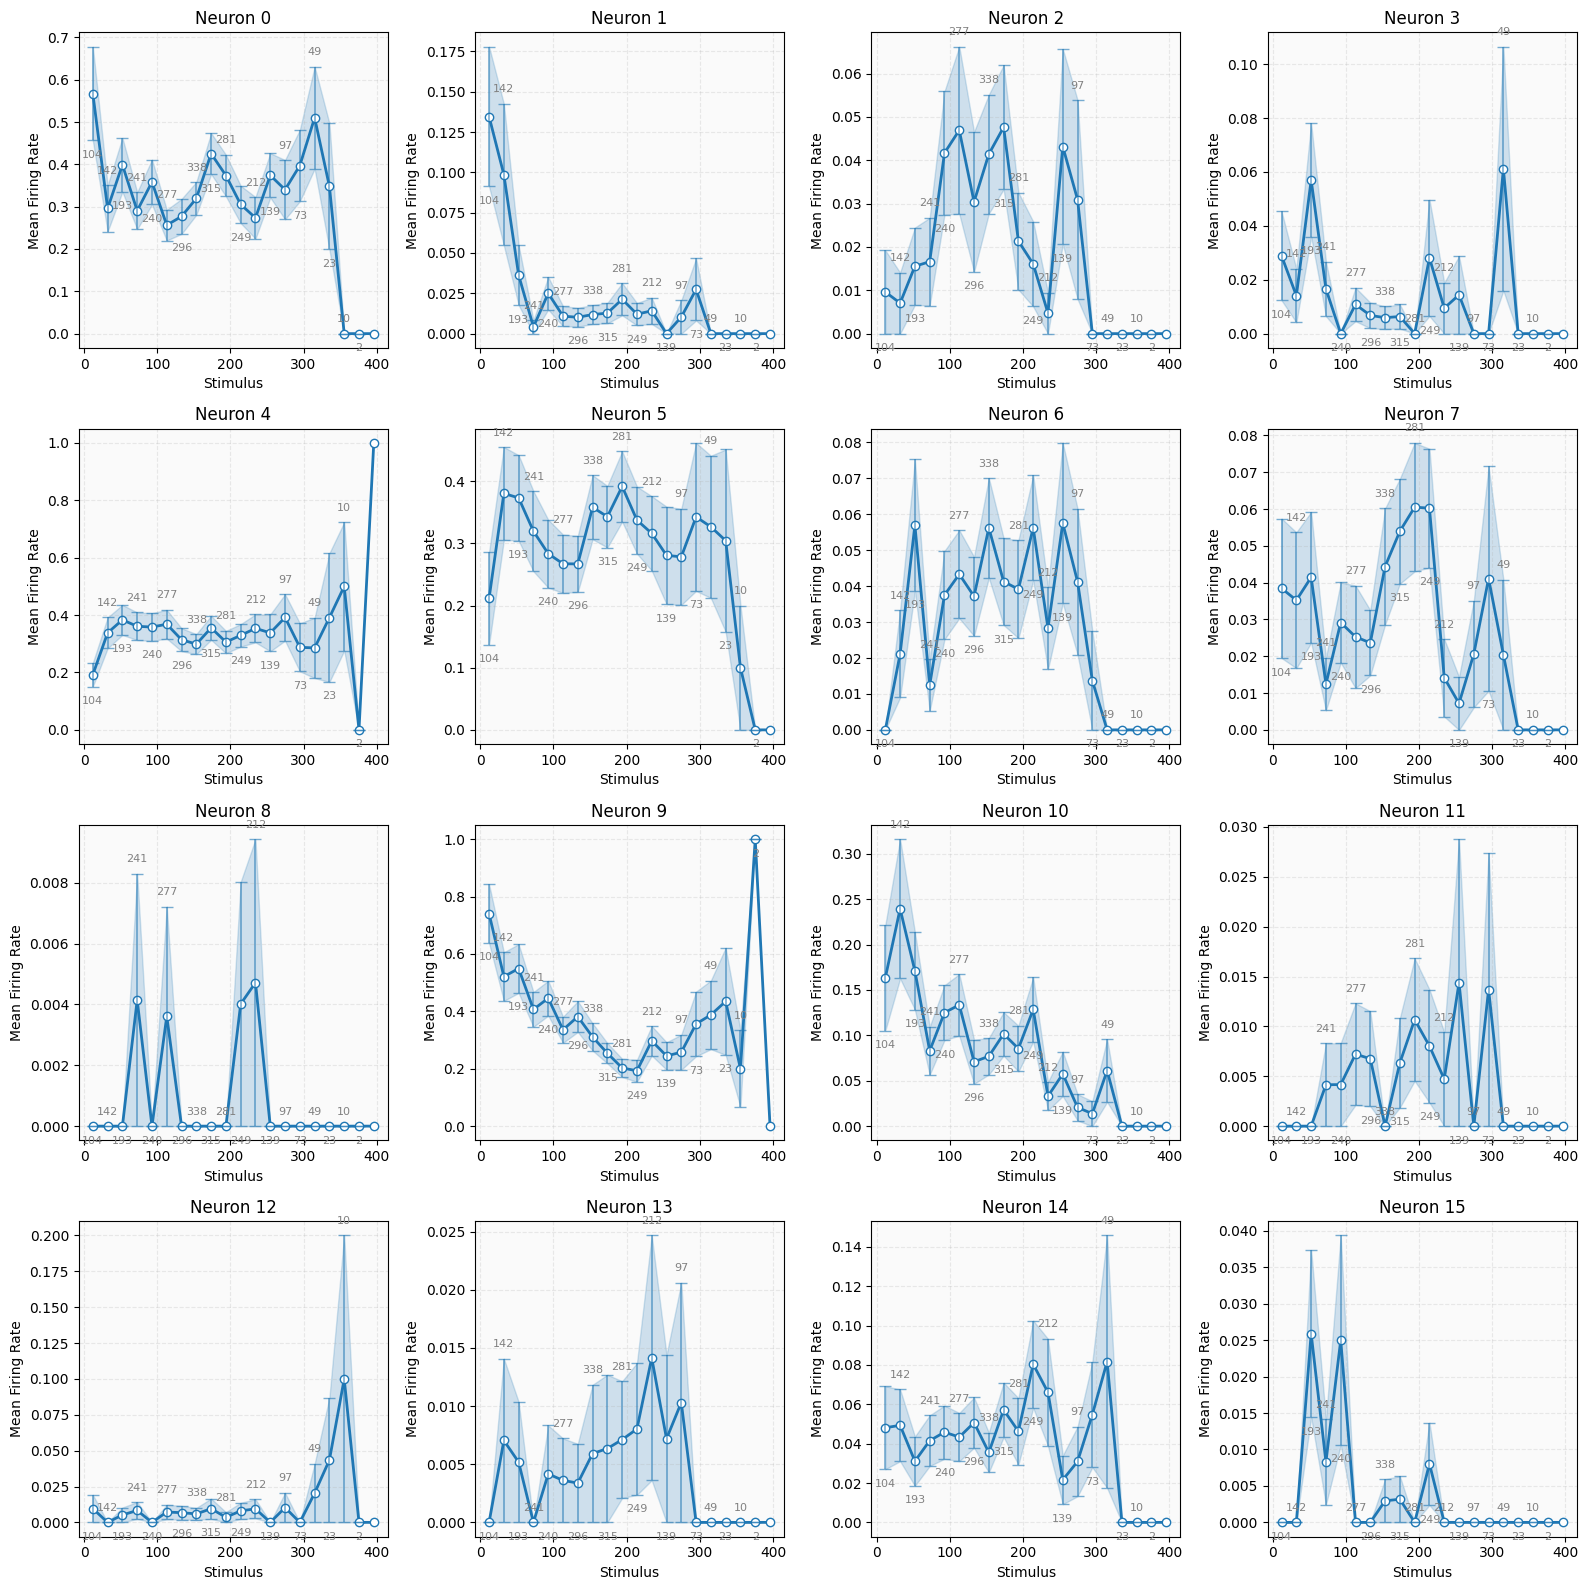

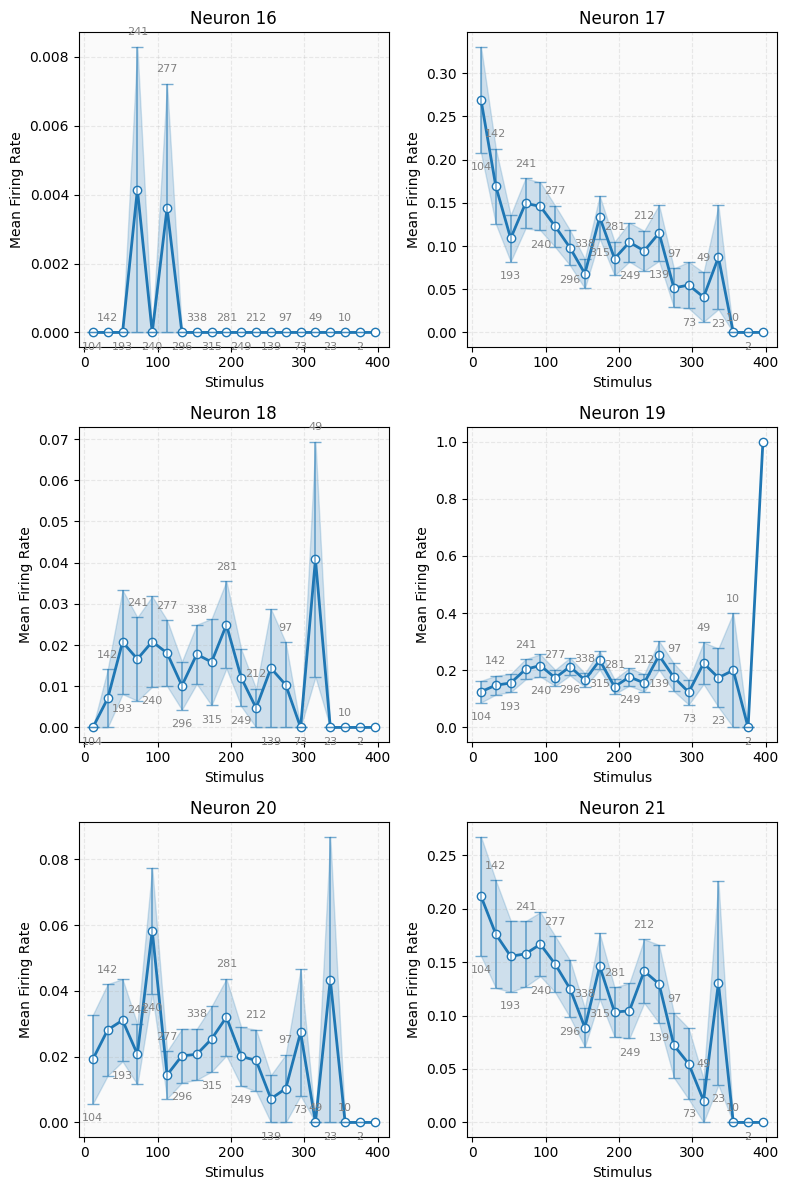

In [ ]:
tuning_curve.plot_tuning_curves(tuning_curves)

# raster + fr

## both

In [ ]:
# distribute data into new_segments and add rel_spike_time
pn.get_new_seg_info(cur_or_nxt='nxt', first_or_last='first', time_limit_to_count_sighting=2, pre_event_window=0.75, post_event_window=0.75, exists_ok=False)

new_seg_info2 = pn.new_seg_info.copy()
new_seg_info2['new_seg_start_time'] = new_seg_info2['event_time'] - 1
new_seg_info2['new_seg_end_time'] = new_seg_info2['stop_time']
aligned_spike_trains = raster_plot.prepare_aligned_spike_trains(new_seg_info2, pn.spikes_df)

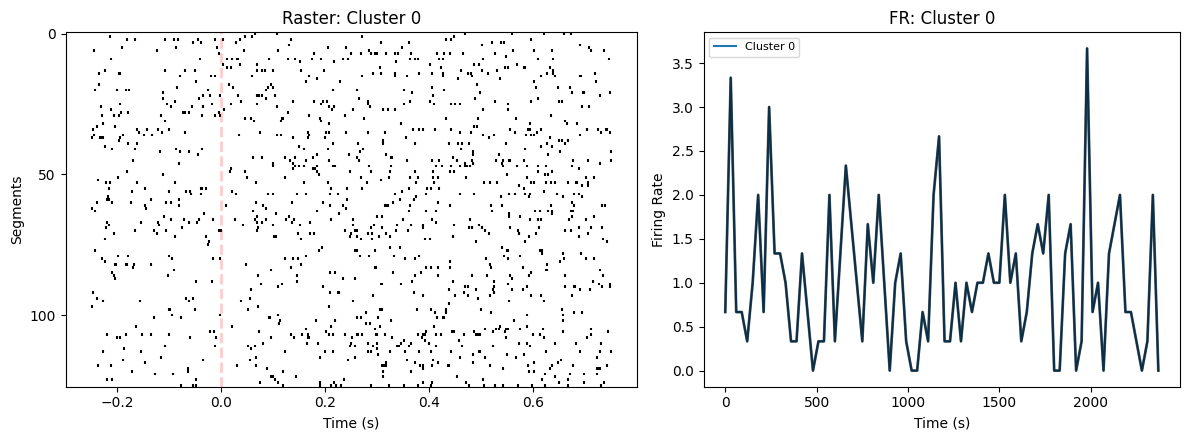

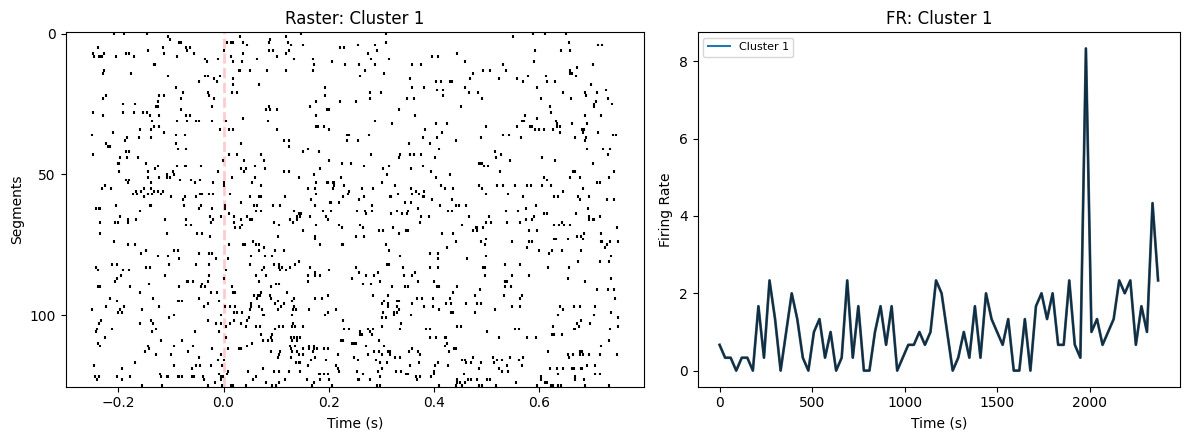

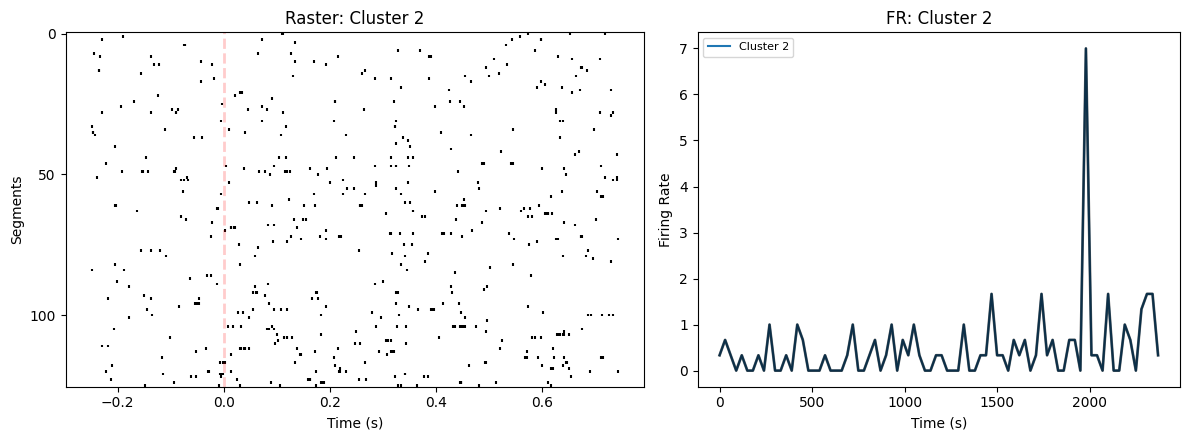

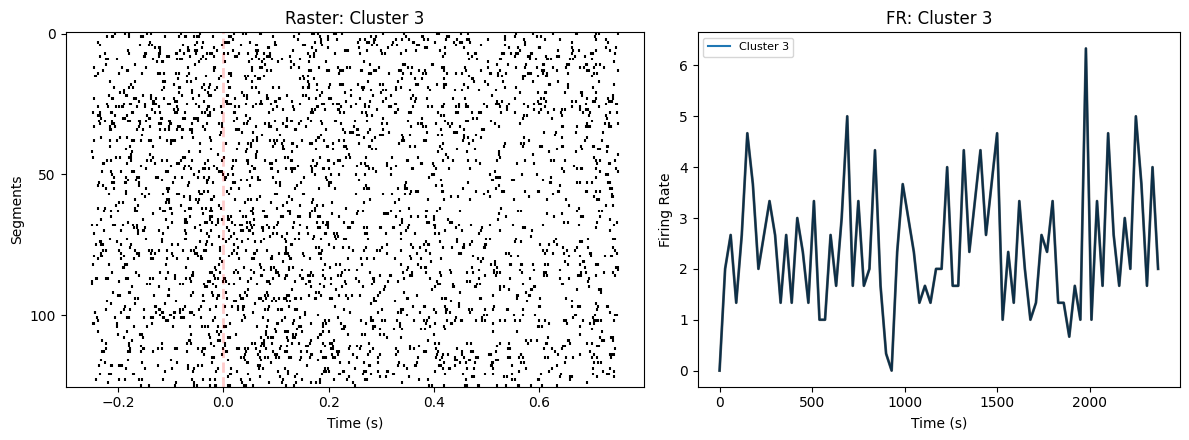

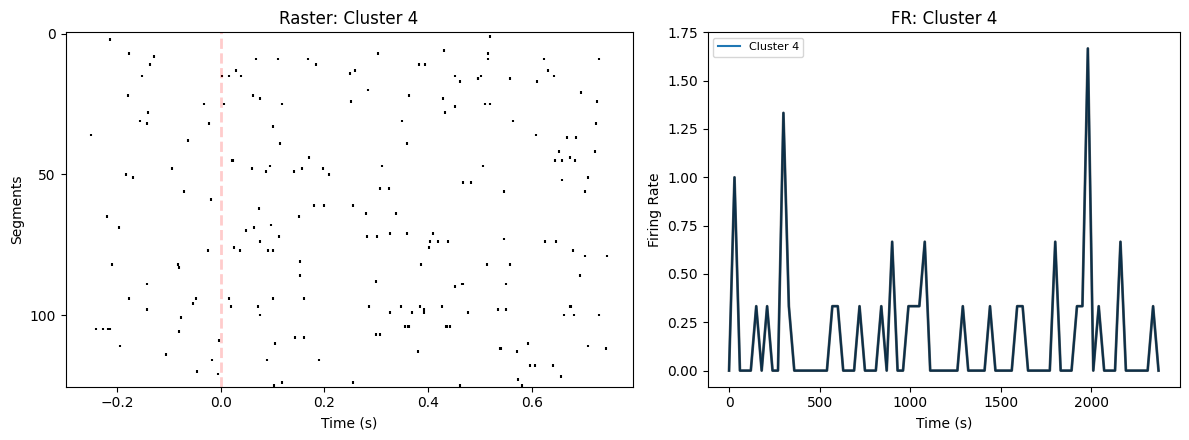

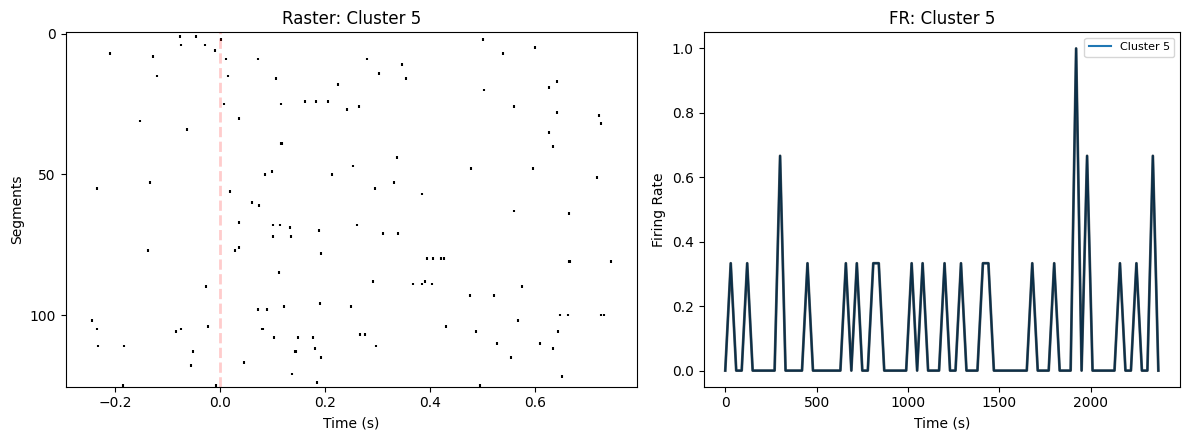

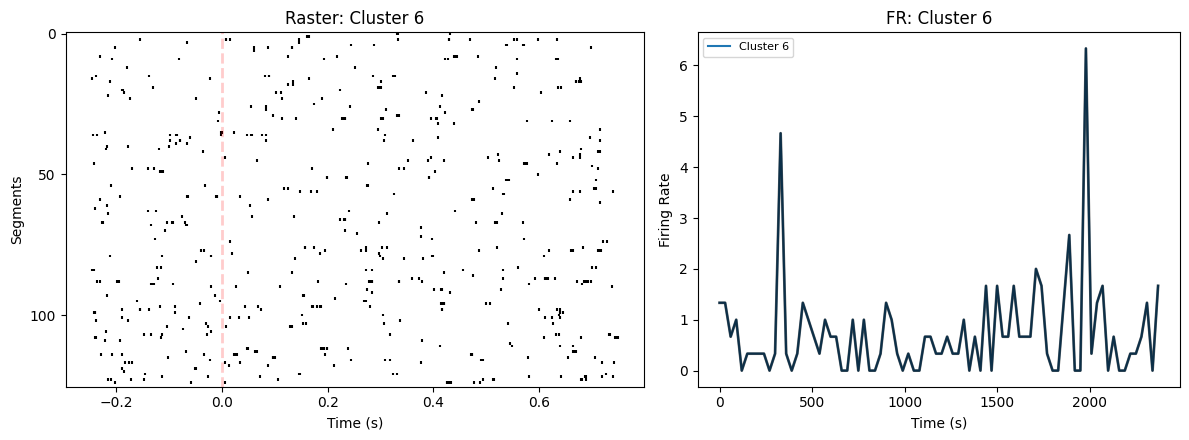

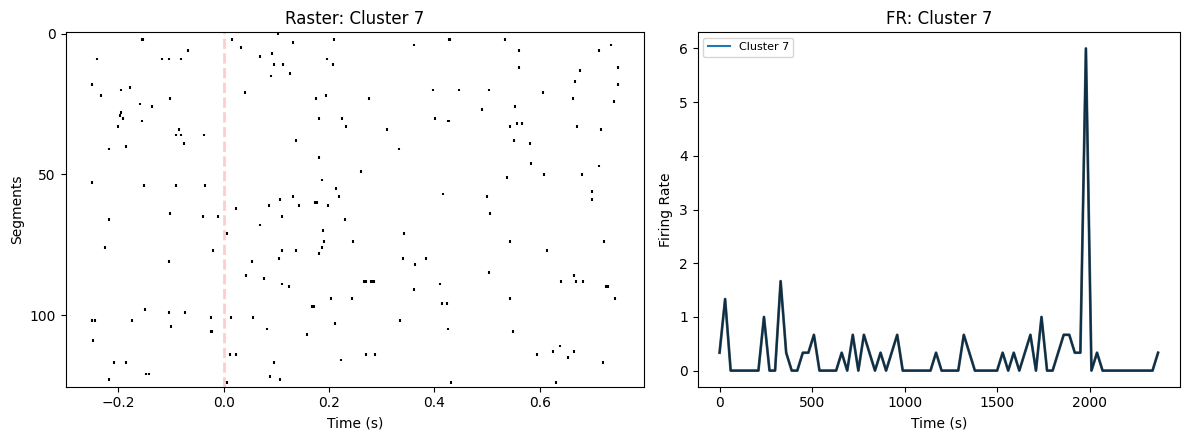

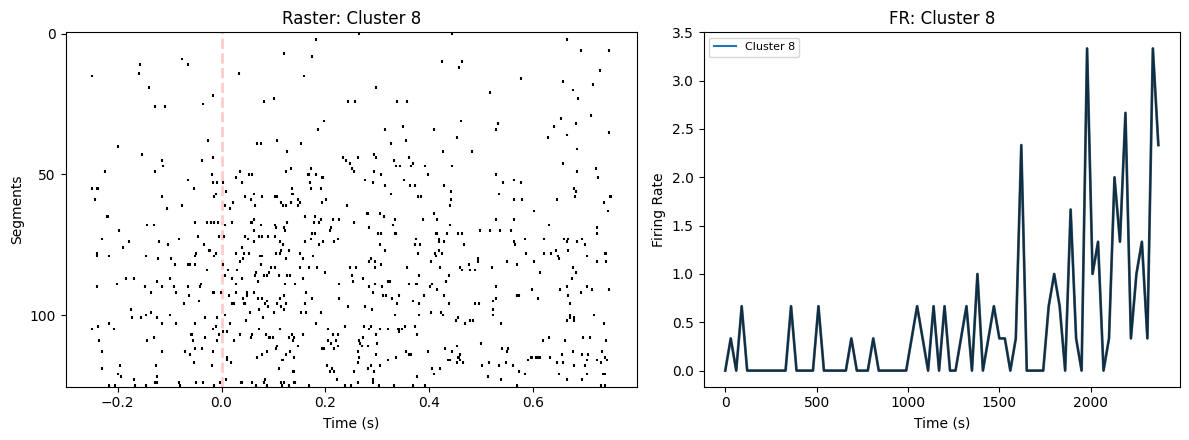

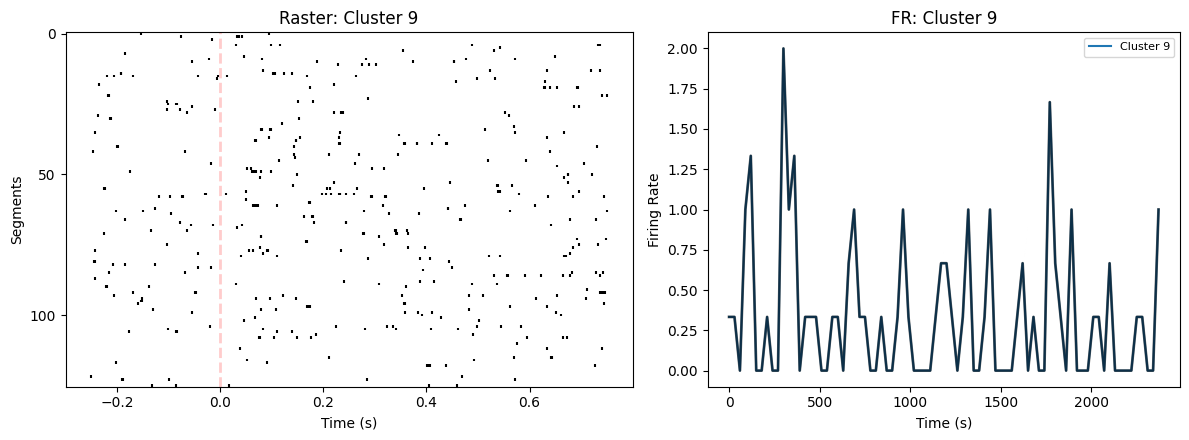

Slope: 0.0000, Total change: 0.4651


In [ ]:
aligned_spike_trains = raster_plot.add_relative_times(aligned_spike_trains, reference_time_col='event_time')
aligned_spike_trains = raster_plot.add_scaling_info(aligned_spike_trains, scale_anchor_col='event_time',
                                                    scale_factor_upper_col='stop_time',
                                                    scale_factor_lower_col='scale_anchor')

raster_plot.plot_rasters_and_fr(
    aligned_spike_trains, new_seg_info2, pn.binned_spikes_df,
    cluster_col='cluster',
    combine_bin_factor=3, plot_mean=True,
    max_clusters_to_plot=10, max_segments_to_plot=None,
    max_time=None
)

## plot rastors only

In [ ]:
# distribute data into new_segments and add rel_spike_time
pn.get_new_seg_info(cur_or_nxt='nxt', first_or_last='first', time_limit_to_count_sighting=2, pre_event_window=0.75, post_event_window=0.75, exists_ok=False)

new_seg_info2 = pn.new_seg_info.copy()
new_seg_info2['new_seg_start_time'] = new_seg_info2['event_time'] - 1
new_seg_info2['new_seg_end_time'] = new_seg_info2['stop_time']
aligned_spike_trains = raster_plot.prepare_aligned_spike_trains(new_seg_info2, pn.spikes_df, pn.bin_width)


new_seg_duration is now 1.5, and post_event_window is now 0.75
Dropped 26 out of 152 segments because of insufficient duration, which is 17.1% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Schro/data_0416/new_seg_info/tlim2_pre0p75_post0p75.csv


In [ ]:
aligned_spike_trains = raster_plot.add_relative_times(aligned_spike_trains, reference_time_col='event_time')
aligned_spike_trains = raster_plot.add_scaling_info(aligned_spike_trains, scale_anchor_col='event_time',
                                                    scale_factor_upper_col='stop_time',
                                                    scale_factor_lower_col='scale_anchor')

raster_plot.plot_rasters(aligned_spike_trains, 
                         max_clusters_to_plot=None,
                         scale_spike_times=True,
                         col_to_rearrange_segments='rel_stop_time',
                         xmin=-0.5,
                        events_to_plot=['rel_event_time', 'rel_stop_time', 
                                        #'rel_prev_ff_caught_time',
                                        #'rel_new_seg_start_time', 'rel_new_seg_end_time'
                                        ])

## plot fr only

In [ ]:
# plot_neural_data.plot_fr_over_time(pn.binned_spikes_df, pn.bin_width, max_time=pn.ff_caught_T_new[-1], combine_bin_factor=3, plot_mean=False, num_clusters_per_plot=1)

## overall fr

In [ ]:
# check num_total_spikes / total_duration
time = pn.binned_spikes_df['bin'].max() * pn.bin_width
pn.binned_spikes_df.sum(axis=0)/ time

cluster_0         9.99645
cluster_1        13.51727
cluster_2         6.47515
cluster_3        22.83597
cluster_4         1.92965
cluster_5         2.23867
cluster_6         7.59103
cluster_7         3.70705
cluster_8         7.04183
cluster_9         5.76851
cluster_10       13.69429
cluster_11       13.02950
cluster_12       16.45634
cluster_13        2.47252
cluster_14       17.48111
cluster_15        7.00189
cluster_16        6.04047
cluster_17        9.95776
cluster_18       15.16094
cluster_19        8.91762
cluster_20       10.16368
cluster_21        6.16882
cluster_22        7.89400
cluster_23       11.46886
cluster_24       10.31919
cluster_25        3.44037
cluster_26        4.49020
cluster_27        5.33911
cluster_28        9.04098
cluster_29        0.68658
cluster_30        6.67924
cluster_31        3.51343
cluster_32       14.02941
cluster_33        2.20862
cluster_34       19.22530
cluster_35        2.89770
cluster_36        1.92389
cluster_37        4.62114
cluster_38  

<Axes: ylabel='Count'>

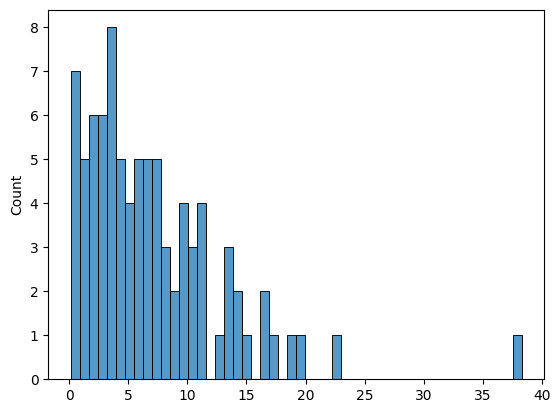

In [ ]:
# histplot of num_total_spikes / total_duration
time = pn.binned_spikes_df['bin'].max() * pn.bin_width
rates = pn.binned_spikes_df.sum(axis=0)/ time
rates = rates.iloc[:-1]
sns.histplot(rates.values, bins=50)

# compare fr

In [ ]:
# distribute data into new_segments and add rel_spike_time
pn.get_new_seg_info(cur_or_nxt='nxt', first_or_last='first', time_limit_to_count_sighting=2, pre_event_window=0.75, post_event_window=0.75, exists_ok=False)

new_seg_duration is now 1.5, and post_event_window is now 0.75
Dropped 26 out of 152 segments because of insufficient duration, which is 17.1% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Schro/data_0416/new_seg_info/tlim2_pre0p75_post0p75.csv
Dropped 55 rows out of 126 due to NA in new_seg_start_time or new_seg_end_time, which is 69.65% of the original data


In [ ]:
time_before_event = 0.9
time_after_event = 0.9
n_bins = 6

new_seg_info2 = pn.new_seg_info.copy()
new_seg_info2['new_seg_start_time'] = new_seg_info2['event_time'] - time_before_event
new_seg_info2['new_seg_end_time'] = new_seg_info2['event_time'] + time_after_event
aligned_spike_trains = raster_plot.prepare_aligned_spike_trains(new_seg_info2, pn.spikes_df)

aligned_spike_trains = raster_plot.add_relative_times(aligned_spike_trains, reference_time_col='event_time')


Dropped 55 rows out of 126 due to NA in new_seg_start_time or new_seg_end_time, which is 69.65% of the original data


In [ ]:
result_df = compare_firing_rate.compare_baseline_vs_post_event_from_spikes(
    aligned_spike_trains,
    pre_window=(-0.3, 0.0),
    post_window=(0.0, 0.3),
    method='wilcoxon'
)
result_df.head(10)

/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


cluster_id  mean_pre  mean_post  mean_diff  p_value  n_trials  \
0           72  13.45029   19.59064    6.14035  0.00799        57   
1           11  17.31183   24.56989    7.25806  0.01721        62   
2           54   7.46032    4.76190   -2.69841  0.02403        21   
3           66   7.05128    5.12821   -1.92308  0.03131        26   
4           16   6.55172    9.19540    2.64368  0.03514        29   
5           75  15.00000   10.83333   -4.16667  0.03566        52   
6           48   9.52381    6.66667   -2.85714  0.03593        14   
7           50  21.56863   26.33987    4.77124  0.03980        51   
8           83   7.87879    3.63636   -4.24242  0.04217        11   
9           23  16.46766   19.10448    2.63682  0.04489        67   
10          21  13.76344    8.92473   -4.83871  0.05122        31   
11           6   6.66667    8.20513    1.53846  0.07555        26   
12          18  14.85876   18.30508    3.44633  0.08418        59   
13          46   6.92308    4.10256   -2.82051  0.10062        13   
14          19   8.97959   11.63265    2.65306  0.10085        49   
15          65  15.20833   12.56944   -2.63889  0.11283        48   
16          42  20.04902   22.15686    2.10784  0.14446        68   
17          40   8.33333    6.66667   -1.66667  0.14684        26   
18           5   3.33333    5.00000    1.66667  0.15730         4   
19          56   3.33333    5.55556    2.22222  0.15730         3   
20          26   9.69697   12.02020    2.32323  0.16767        33   
21          85   5.33333    3.33333   -2.00000  0.17971         5   
22          60  17.10383   19.78142    2.67760  0.18133        61   
23          15  10.29412    9.01961   -1.27451  0.20033        34   
24          81   8.93939   10.60606    1.66667  0.26495        44   
25          77   5.92593    6.91358    0.98765  0.27137        27   
26          84   4.58333    7.50000    2.91667  0.27332         8   
27           8   9.77011   11.26437    1.49425  0.27682        29   
28          53   8.93939    7.27273   -1.66667  0.28800        22   
29          49  15.78947   17.89474    2.10526  0.31518        57   
30          71   3.33333    3.88889    0.55556  0.31731         6   
31          51   7.50000    6.66667   -0.83333  0.31731         4   
32          17  14.56790   12.22222   -2.34568  0.33763        27   
33          33   8.61111    6.11111   -2.50000  0.36917        12   
34          25   5.55556    4.44444   -1.11111  0.39776        12   
35          13   4.58333    5.41667    0.83333  0.42974        16   
36          73   8.39506    6.91358   -1.48148  0.47024        27   
37          58  10.42553    9.50355   -0.92199  0.47151        47   
38          28   9.80392    9.08497   -0.71895  0.47736        51   
39          31   7.17949    6.15385   -1.02564  0.47784        13   
40          27   8.33333    8.33333    0.00000  0.48270        44   
41          43   6.66667    5.23810   -1.42857  0.49624         7   
42          59   9.01961    8.03922   -0.98039  0.50233        17   
43          41   8.84615    9.55128    0.70513  0.50459        52   
44          68   5.88235    6.66667    0.78431  0.52555        17   
45          14  12.76190   13.80952    1.04762  0.53853        35   
46          10  15.69892   16.93548    1.23656  0.54616        62   
47           4   6.19048    4.76190   -1.42857  0.58071         7   
48          12  19.66667   18.71429   -0.95238  0.58927        70   
49          36   6.25000    5.00000   -1.25000  0.59298         8   
50           1  10.72222   11.72222    1.00000  0.60363        60   
51          62   5.75758    6.66667    0.90909  0.60558        11   
52          67   7.50000    8.05556    0.55556  0.61054        36   
53          82   5.00000    6.66667    1.66667  0.62500         4   
54          76   4.54545    4.84848    0.30303  0.65472        11   
55          24  10.72222   10.88889    0.16667  0.65875        60   
56          57  11.83908   12.35632    0.51724  0.66969        58   
57

In [ ]:
clusters = [11, 17, 19, 21, 50, 54]
result_df[result_df['cluster_id'].isin(clusters)]

cluster_id  mean_pre  mean_post  mean_diff  p_value  n_trials
6           11  17.31183   24.56989    7.25806  0.01721        62
17          54   7.46032    4.76190   -2.69841  0.02403        21
0           50  21.56863   26.33987    4.77124  0.03980        51
55          21  13.76344    8.92473   -4.83871  0.05122        31
23          19   8.97959   11.63265    2.65306  0.10085        49
48          17  14.56790   12.22222   -2.34568  0.33763        27